# Corpus semantic & syntactic analysis
In this notebooks, I'll explore the following analyses of corpus semantics and syntactics:
1. **Vocabulary analysis.** Look for out-of-vocabulary words in each pairwise comparison of corpora. The more out-of-vocabulary words for a given pair, the less similar they are to one another. Expect that SciERC and PICKLE will have more overlapping vocabulary.
2. **Token analysis.** Using a word2vec model, embed the tokens from each corpus, and see how they cluster in the vector space. Expect that PICKLE and SciERC tokens will cluster together in space.
3. **Document analysis.** Using some kind of document embedding (doc2vec, a BERT based embedding, etc), perform the same style of analysis as for the tokens. Expect PICKLE and SciERC documents to cluster together more often.

## 1. Vocabulary analysis
### Getting our corpus vocabularies
For this analysis, we'll use the SciERC, GENIA, and PICKLE corpora to get the sets of tokens that make up the three corpora. We'll then look for out-of-vocabulary words in each pairwise comparison of corpora. Based on the pre-trained model results, we expect to see that there are more out-of-vocabulary words in the GENIA-PICKLE comparison than in the SciERC-PICKLE comparison.

#### Downloading SciERC and GENIA data
We'll use the code provided in the [DyGIE++](https://github.com/dwadden/dygiepp) repo for this purpose, running the following commands:

```
bash ./scripts/data/get_scierc.sh
```

```
bash ./scripts/data/get_genia.sh
```

-----------
## Experimenting with plotting word vectors
Temporary playground for code that will be moved to the corpus comparison script.

In [1]:
from gensim.models import KeyedVectors
import sys
sys.path.append('../models/corpus_comparison/')
from dataset import Dataset
import jsonlines
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# Import the word vectors
word2vecs = '../data/straying_off_topic_data/corpus_comparison/pickle_scierc_genia_combined_word2vec_skipgram.wordvectors'
vecs = KeyedVectors.load(word2vecs)

In [3]:
# Import the datasets
def read_dataset(path, name):
    """
    Read in a dataset to a Dataset object.
    """
    objs = []
    with jsonlines.open(scierc_path) as reader:
        for obj in reader:
            objs.append(obj)
            
    dset = Dataset(name, objs)
    
    return dset

In [4]:
scierc_path = '../../dygiepp/data/scierc/processed_data/json/train.json'
genia_path = '../../dygiepp/data/genia/processed-data/json-coref-ident-only/train.json'
pickle_path = '../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/FINAL_ENTITIES_all_gold_standard_abstracts_GOLD_STD_03Mar2022.jsonl'

scierc = read_dataset(scierc_path, 'scierc')
genia = read_dataset(genia_path, 'genia')
pickle = read_dataset(pickle_path, 'pickle')

In [5]:
# Sort vectors
sep_vecs = {}
for dset in [scierc, genia, pickle]:
    _ = dset.get_dataset_vocab()
    dset_comb_vocab = list(dset.vocab['unigrams']) + list(dset.vocab['bigrams']) + list(dset.vocab['trigrams'])
    dset_vecs = {k:vecs[k] for k in vecs.index_to_key if k in dset_comb_vocab}
    sep_vecs[dset.get_dataset_name()] = dset_vecs

{'orange', 'blue', 'green'}


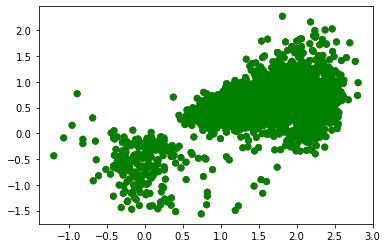

In [13]:
# Do PCA to get plottable shaped vectors
# Fit on all the vectors, then transform each individually to keep the sorted structure

# Make input array
X = []
for k in vecs.index_to_key:
    X.append(vecs[k])

# Fit PCA
pca = PCA(n_components=2)
pca.fit(X)

# Transform the vectors
x, y, group = [], [], []
for dset in sep_vecs:
    for word in sep_vecs[dset]:
        word_vec = sep_vecs[dset][word].reshape(1, -1)
        transformed = pca.transform(word_vec).flatten()
        x.append(transformed[0])
        y.append(transformed[1])
        group.append(dset)
        
# Plot
color_dict = {'scierc': 'blue', 'genia':'orange', 'pickle':'green'}
colors = [color_dict[i] for i in group]
plt.scatter(x=x, y=y, c=colors)
plt.show()

In [ ]:
# Troubleshooting